# AIE Workshop - Julia for Computational Modelling
## Part 2: Neural networks with `Flux.jl`

- **Speaker**: Fabricio Oliveira 
- **Contact**: fabricio.oliveira@aalto.fi | [gamma-opt.aalto.fi](https://gamma-opt.aalto.fi/)

### Example 1: MNIST

Let's start from a simple example and develop a simple fully connected neural network for predicting digits using the MNIST dataset.

In [1]:
using Flux 
using BSON          # for saving trained model
using MLDatasets    # interface for common ML datasets; BSON is 
using MLUtils       # For data manipulation
using Surrogates    # For sampling

using LinearAlgebra, Random, Statistics, Plots, Images
Random.seed!(1);

This gives us an idea of the sizes of our preset train and test splits.

In [ ]:
x_train_raw, y_train_raw = MNIST(split=:train)[:] 
x_test_raw, y_test_raw = MNIST(split=:test)[:]

@show summary(x_train_raw)
@show summary(x_test_raw);

Let's have a look at some examples of our data

In [ ]:
println("labels =  $(y_train_raw[1:5])") 
img = [x_train_raw[:, :, i]' |> colorview(Gray) for i=1:5]  # or use convert2image()

Preparing the data to input our network. Simply means flattening the image to a vector and doing a one-hot encoding of the classes

In [ ]:
x_train = Flux.flatten(x_train_raw) # single input layer
x_test = Flux.flatten(x_test_raw)   #

size(x_train) # 28 x 28 = 784

In [ ]:
y_train = Flux.onehotbatch(y_train_raw, 0:9)
y_test = Flux.onehotbatch(y_test_raw, 0:9)

Now `Flux.jl` really start to show its role. We will startt by defining our model. We choose a very simple fully connected (i.e., `Dense`) network with ReLU activation layers. At the very end, we input a softmax to decide on the classification.

In [ ]:
model_MLP = Chain(
    Dense(28 * 28, 32, relu),
    Dense(32, 128, relu),
    Dense(128, 64, relu),
    Dense(64, 10),
    softmax
)

In `Flux.jl` we have the freedom to define whatever we want as our loss function. Notice we simply used the readly available `Flux.crossentropy`, but we could have defined our own rather trivially.

In [ ]:
# sqnorm(x) = sum(abs2, x)
loss(model, x, y) = Flux.crossentropy(model(x), y) #+ sum(sqnorm, Flux.params(model))


# Showcasing equivalence in function definiton while pretting-up things
function calculate_loss(model, data)
    return loss(model, data[1][1], data[1][2])
end

Setting up the optimiser to be used in the training. 

In [ ]:
η = 0.001 # learning rate
opt = Flux.setup(ADAM(η), model_MLP)

In [ ]:
train_data = [(x_train, y_train)]
loss_progression = []
epochs = 200

# Main training loop
for epoch in 1:epochs
   Flux.train!(loss, model_MLP, train_data, opt)  # Tensorflow style training. 
    
    # Logging; you can use @withprogress from ProgressLogging.jl instead  
    l = calculate_loss(model_MLP, train_data)
    push!(loss_progression, l)
    if mod(epoch, 10) == 1  
        println("epoch=$epoch : train_loss=$l")
    end
end

plot(loss_progression, xlabel = "epochs", ylabel = "loss", legend=false)

Let's implement a function to calculate our accuracy on the test set

In [ ]:
function calculate_accuracy(model, x, y)
    y_hat = model(x)
    iscorrect = Flux.onecold(y_hat) .== Flux.onecold(y)         # onecold is the inverse of onehot encoding
    return accuracy = round(100 * mean(iscorrect); digits=2)
end

calculate_accuracy(model_MLP, x_test, y_test)

Let's look as some exemplars in the test set and see how well our model does

In [ ]:
index = 42
img = x_test_raw[:, :, index]' |> colorview(Gray) 

In [ ]:
prediction = model_MLP(x_test[:,index])
println("Recognised digit: ", Flux.onecold(prediction, 0:9))
println("Digit label: ", y_test_raw[index])  

## Example 2 - CIFAR10 with CNNs

Let's try something a bit more sophisticated. Our main urpose is to showcase a few more standard yet more advanced features from `Flux.jl`

In [2]:
using MLDatasets: CIFAR10
using .Iterators # Packages from Base have this .

I am using Julia's native `Iterators.jl` to batch my training data into 1000 datapoints batches. If you need more sophisticated data loaders, say due to memory limitations or too large datasets, consider `Flux.DataLoader()`

In [3]:
train_x, train_y = CIFAR10(split=:train)[:]
labels = Flux.onehotbatch(train_y, 0:9)

train_data = ([(train_x[:,:,:,i], labels[:,i]) for i in partition(1:49000, 1000)])

validaton_set = 49001:50000
validation_x = train_x[:,:,:,validaton_set]
validation_y = labels[:, validaton_set]

10×1000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅

Labeled class: (3 => "cat")


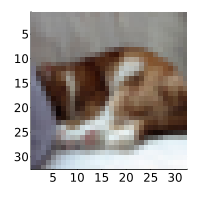

In [4]:
index = rand(1:49000) 
image(x) = colorview(RGB, permutedims(x, (3, 2, 1)))

classes = (
    0 => "airplane",
    1 => "automobile",
    2 => "bird",
    3 => "cat",
    4 => "deer",
    5 => "dog",
    6 => "frog",
    7 => "horse",
    8 => "ship",
    9 => "truck"
)

println("Labeled class: ($(classes[train_y[index] + 1]))")

plot(image(train_x[:,:,:,index]), size = (200,200))


Here is our model. Now we use a few convolution layers before inputting it into a set of dense layers

In [ ]:
CNN_model = Chain(
  Conv((5,5), 3=>16, relu),
  MaxPool((2,2)),
  Conv((5,5), 16=>8, relu),
  MaxPool((2,2)),
  x -> reshape(x, :, size(x, 4)),
  Dense(200, 120),
  Dense(120, 84),
  Dense(84, 10),
  softmax)

Setting up the loss, the optimisation method we will use and an accuracy measure so we can log it during training.

In [9]:
loss(x, y, model) = sum(Flux.crossentropy(model(x), y))
accuracy(x, y, model) = mean(Flux.onecold(model(x), 0:9) .== Flux.onecold(y, 0:9))

accuracy (generic function with 1 method)

In [ ]:
using Flux: params, update!

epochs = 15
opt = Momentum(0.01)

# This takes about 1 min per epoch on my 2019 Macbook pro M1
for epoch = 1:epochs
  for d in train_data
    gs = gradient(params(CNN_model)) do # "with respect to"
      l = loss(d..., CNN_model)
    end
    update!(opt, params(CNN_model), gs)
  end
  println("epoch $(epoch) finished. acc.: $(accuracy(validation_x, validation_y, CNN_model))")
end

As this is an expensive task, we don't want to keep doing it. Here is one way we can store our trained model, using Binary JSON (BSON)

In [ ]:
BSON.@save "CNN_model.bson" CNN_model

In [5]:
BSON.@load "CNN_model.bson" CNN_model

In [6]:
test_x, test_y = CIFAR10(split=:test)[:]
test_labels = Flux.onehotbatch(test_y, 0:9)

10×10000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  …  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

Predicted class: 9 (9 => "truck")
True class: 9 (9 => "truck")


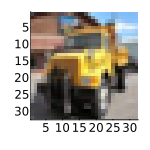

In [7]:
classes = (
    0 => "airplane",
    1 => "automobile",
    2 => "bird",
    3 => "cat",
    4 => "deer",
    5 => "dog",
    6 => "frog",
    7 => "horse",
    8 => "ship",
    9 => "truck"
)

index = rand(1:10000)

rand_test = test_x[:,:,:,[index]] 
rand_truth = test_y[index]
prediction = Flux.onecold(CNN_model(rand_test), 0:9)[1]

println("Predicted class: $(prediction) ($(classes[(prediction) + 1]))")
println("True class: $(rand_truth) ($(classes[(rand_truth) + 1]))")

img = test_x[:,:,:,index]
plot(image(img), size = (150,150))

In [10]:
accuracy(test_x, test_labels, CNN_model)

0.5183

# Example 3 - Inverse optimisation

Let's do something a bit more sophisticated now. Because of Julia's natural function oriented paradigm, we can treat trained NN as functions, and do things such as calculate *gradients*, which we can use in our favour!

Our task will be to try to train a NN that can learn the "shape" of an unknown function. We assume that all we have are inputs and evatuations of this function. 

In [ ]:
# Styblinski–Tang function
f(x::Tuple) = 0.5 * sum([xi^4 - 16*xi^2 + 5*xi for xi in x])

num_samples = 1000
lb = Float32[-4.0, -4.0]
ub = Float32[0.0, 0.0]

T2M(x::Vector) = Float32.(reshape(collect(Iterators.flatten(x)), length(x[1]), length(x)))

x_tuple = Surrogates.sample(num_samples, [lb, ub]..., SobolSample())
x = T2M(x_tuple)
y = T2M(f.(x_tuple))

train_data, test_data = splitobs((x, y), at = 0.8) # from MLUtils.jl

# assign the data
x_train, y_train = train_data[1], train_data[2]
x_test, y_test = test_data[1], test_data[2];

Now that our data is in the format we need, let's set p and train a NN that learns the underlying relationship (i.e., function) between the inputs $x$ and outputs $y$. 

We start by building our model and setting its parameterisation

In [ ]:
# build the model
model = Chain(
    Dense(2, 512, relu),
    Dense(512, 256, relu),
    Dense(256, 1)
)

opt = ADAM()                        # our optimiser
loss(model, x, y) = Flux.mse(model(x), y)  # our loss

In [ ]:
loss_progression = []
epochs = 2000

for epoch in 1:epochs
    Flux.train!(loss, Flux.params(model), [(x_train, y_train)], opt)
    # Logging
    l = loss(x_train, y_train)
    push!(loss_progression, l)
    if mod(epoch, 10) == 1 || epoch == epochs
        println("epoch=$epoch : train_loss=$l")
    end
end

Let's have a look at our training loss

In [ ]:
plot(1:epochs, loss_progression,
    xlabel = "Epochs",
    ylabel = "Loss",
    legend = false,
)

And make sure we check for overfitting

In [ ]:
test_loss = loss(x_test, y_test)
println("Test Loss = $test_loss")

Now we are ready to optimise our trained surrogate. Because `model()` can essentially be seen as a function, it also means that we can calculate gradients from it with respect to its inputs!

Let's implement a very simple gradient descent method for the task

In [ ]:
x₀ = Float32.([0,0])  
max_iter = 100
θ = 0.01
trajectory = zeros(3, max_iter)

xₖ = x₀
for k =1:max_iter
    ∇ₖ = Flux.jacobian(x -> model(x), xₖ)[1] # calculate gradient
    xₖ = xₖ .- θ .* ∇ₖ'
    trajectory[1:2,k] = xₖ
    trajectory[3,k] = model(xₖ)[1]
    println("Iteration $k: f(xₖ)=$(model(xₖ)[1])")
end

We can see what was the final optimal point and compare against the ground truth, for validation

In [ ]:
println("Final optimised position: [$(round(xₖ[1], digits=4)), $(round(xₖ[2], digits=4))]")
println("            Model Output: $(round(model(xₖ)[1], digits=4))")
println("  Actual Function Output: $(round(f(Tuple(xₖ)), digits=4))")

In [ ]:
x, y = Float32.(-4.0:0.02:0.0), Float32.(-4.0:0.02:0.0) # To use model() we need Float32
z_true = [f((x1,x2)) for x1 in x, x2 in y]
z_surrogate = [model([x1, x2])[1] for x1 in x, x2 in y] 

p1 = surface(x, y, z_true, clims = (-80, -20), colorbar = false)
scatter!(p1, [xₖ[1]], [xₖ[2]], [f(Tuple(xₖ))], legend = false)
annotate!(p1, [(xₖ[1], xₖ[2], f(Tuple(xₖ))-6, text("x-opt", 10))])

p2 = surface(x, y, z_surrogate, clims = (-80, -20), colorbar = false)
scatter!(p2, trajectory[1,:], trajectory[2,:], trajectory[3,:], legend = false)
scatter!(p2, [xₖ[1]], [xₖ[2]], [model(xₖ)[1]], legend = false)
annotate!(p2, [(xₖ[1], xₖ[2], model(xₖ)[1]-6, text("x-opt", :10))])

plot(p1, p2, 
    title=["True function" "Surrogate model"], 
    titlefontsize = 12,
    zlims = (-80, -20),
    xlabel = ["x₁" "x₁"], ylabel = ["x₂" "x₂"],
    zlabel = ["y" "y"],
    layout=(1,2), 
    size=(900, 400)
)

In [ ]:
p1 = contour(x, y, z_true, clims = (-80, -10))
scatter!(p1, [xₖ[1]], [xₖ[2]], legend = false)
annotate!(p1, [(xₖ[1], xₖ[2]-0.15, text("x-opt", 10))])

p2 = contour(x, y, z_surrogate, clims = (-80, -10))
scatter!(p2, trajectory[1,:], trajectory[2,:], legend = false)
scatter!(p2, [xₖ[1]], [xₖ[2]], legend = false)
annotate!(p2, [(xₖ[1], xₖ[2]-0.15, text("x-opt", 10))])

plot(p1, p2, 
    title=["True function" "Surrogate model"],
    titlefontsize = 12, 
    xlabel = ["x₁" "x₁"], ylabel = ["x₂" "x₂"],
    layout=(1,2), 
    size=(900, 400),
)